In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns


C:\Users\patan Nishath khan\AppData\Local\Temp\ipykernel_12160\934597570.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import pandas as pd

In [3]:
# Load datasets
customers = pd.read_csv("C:\\Users\\patan Nishath khan\\Downloads\\Customers.csv")
transactions = pd.read_csv("C:\\Users\\patan Nishath khan\\Downloads\\Transactions.csv")


In [4]:
# Merge customers and transactions
transactions_with_customers = transactions.merge(customers, on="CustomerID")

# Aggregate transaction data by customer
customer_transactions = transactions_with_customers.groupby("CustomerID").agg(
    TotalSpent=("TotalValue", "sum"),
    TotalTransactions=("TransactionID", "count"),
    AvgTransactionValue=("TotalValue", "mean")
).reset_index()

# Merge with customer profiles
customer_profile = customers.merge(customer_transactions, on="CustomerID", how="left").fillna(0)


In [5]:
# Encode region as numerical values
region_mapping = {region: idx for idx, region in enumerate(customer_profile["Region"].unique())}
customer_profile["RegionEncoded"] = customer_profile["Region"].map(region_mapping)

# Select features for clustering
features = ["TotalSpent", "TotalTransactions", "AvgTransactionValue", "RegionEncoded"]

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_profile[features])


In [6]:
# Range of clusters to evaluate
clusters_range = range(2, 11)
db_scores = []
kmeans_models = {}

for n_clusters in clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, cluster_labels)
    db_scores.append(db_index)
    kmeans_models[n_clusters] = (kmeans, cluster_labels, db_index)

# Determine the best number of clusters (lowest DB Index)
best_n_clusters = clusters_range[db_scores.index(min(db_scores))]
best_kmeans, best_labels, best_db_index = kmeans_models[best_n_clusters]

# Add cluster labels to the customer profile
customer_profile["Cluster"] = best_labels


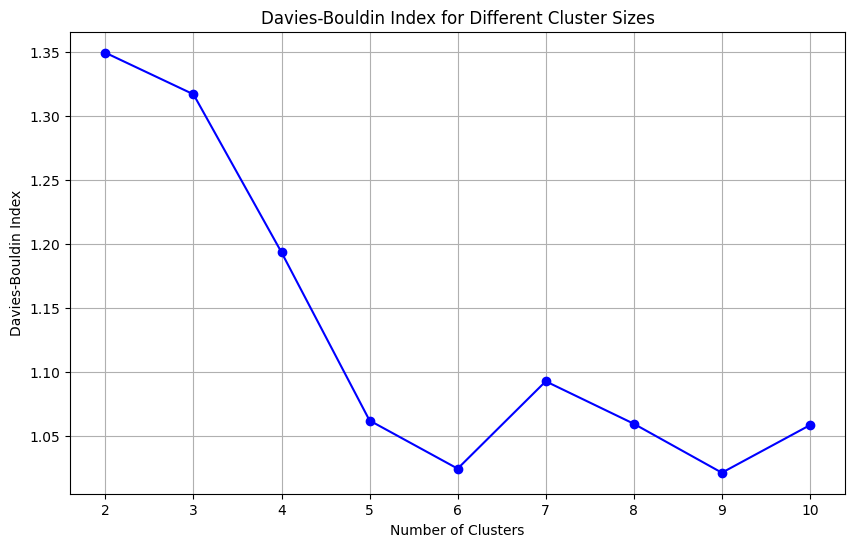

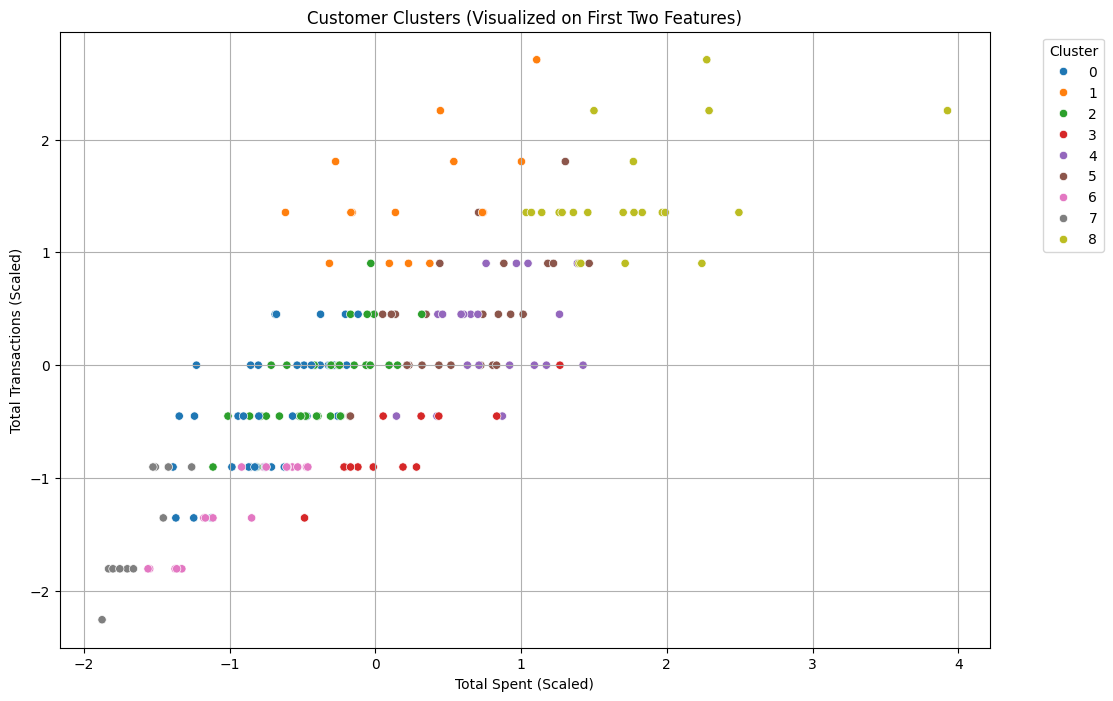

In [7]:
# Plot DB Index values
plt.figure(figsize=(10, 6))
plt.plot(clusters_range, db_scores, marker='o', linestyle='-', color='b')
plt.title('Davies-Bouldin Index for Different Cluster Sizes')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.grid(True)
plt.show()

# Visualize clusters using the first two features
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=scaled_features[:, 0],  # TotalSpent (scaled)
    y=scaled_features[:, 1],  # TotalTransactions (scaled)
    hue=customer_profile["Cluster"],
    palette="tab10",
    legend="full"
)
plt.title("Customer Clusters (Visualized on First Two Features)")
plt.xlabel("Total Spent (Scaled)")
plt.ylabel("Total Transactions (Scaled)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.show()


In [8]:
# Summarize clusters
cluster_summary = customer_profile.groupby("Cluster").agg({
    "TotalSpent": "mean",
    "TotalTransactions": "mean",
    "AvgTransactionValue": "mean",
    "RegionEncoded": "mean"
}).rename(columns={"RegionEncoded": "AvgRegionEncoding"})

print(cluster_summary)


          TotalSpent  TotalTransactions  AvgTransactionValue  \
Cluster                                                        
0        2159.107895           4.210526           526.286057   
1        3925.439333           8.266667           476.612335   
2        2780.135294           4.647059           600.179730   
3        3756.365385           3.384615          1117.839692   
4        4894.143810           5.571429           899.303034   
5        4561.785000           5.923077           780.714855   
6        1658.763158           2.157895           781.649386   
7         445.759167           1.666667           231.075139   
8        6702.794545           8.272727           815.190195   

         AvgRegionEncoding  
Cluster                     
0                 2.578947  
1                 1.400000  
2                 0.352941  
3                 2.307692  
4                 0.190476  
5                 2.730769  
6                 0.894737  
7                 1.166667  
8    

In [9]:
# Save cluster assignments
customer_clusters_path = "C:\\Users\\patan Nishath khan\\Downloads\\Customer_Clusters.csv"
customer_profile[["CustomerID", "Cluster"]].to_csv(customer_clusters_path, index=False)

# Save cluster summary
cluster_summary_path = "C:\\Users\\patan Nishath khan\\Downloads\\Cluster_Summary.csv"
cluster_summary.to_csv(cluster_summary_path)

print(f"Cluster assignments saved to {customer_clusters_path}")
print(f"Cluster summary saved to {cluster_summary_path}")


Cluster assignments saved to C:\Users\patan Nishath khan\Downloads\Customer_Clusters.csv
Cluster summary saved to C:\Users\patan Nishath khan\Downloads\Cluster_Summary.csv
